f = 0.5753616000485844


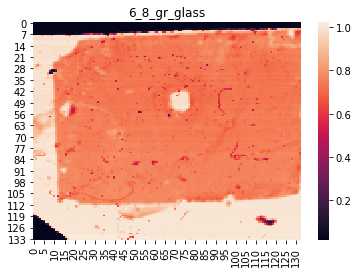

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater


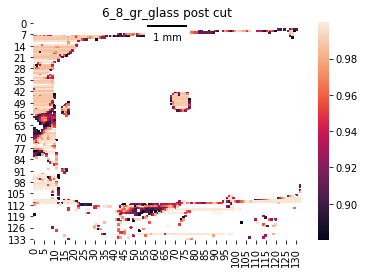

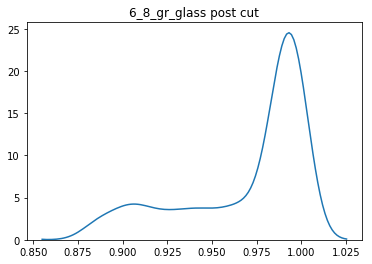

How many peaks are present? 0


IndexError: index -2 is out of bounds for axis 0 with size 0

In [1]:
# Code to calculate presence of graphene based on transmission measurement. Non-smaple data are cut using np masks
# Sample data are used to calculated PDF via KDE. Peaks in KDE are fit to Gaussian curves. Width of lower transmission
# peak is used to determine single layer gr coverage. Width of higher transmission and all other data are assumed to be
# pure polymer. Histogram and discrete layer number assignments are made from these widths. Gr coverage is calculated from
# bins in bin widths, peak area ratio, and peak height ratio

%matplotlib inline
%run get_heatmap.ipynb

#Import necessary packages
import numpy as np; import pandas as pd; import seaborn as sb; import matplotlib.pyplot as plt;
import statsmodels.api as sm; from scipy.optimize import curve_fit; import scipy.stats as stats; 
import statsmodels.stats.proportion as smsp; from matplotlib.colors import LinearSegmentedColormap; 
from matplotlib_scalebar.scalebar import ScaleBar;

def bootstrap(data):
    sampleProps=[]; data=np.sort(data);
    for _ in range(10000):
        samples=np.random.choice(data,size=len(data),replace=True);
        sampleProps.append(samples.mean());
    return np.mean(sampleProps), np.std(sampleProps), np.percentile(sampleProps,[2.5,97.5])

def gauss(x,*params):
    y=np.zeros_like(x);
    for i in range(0,len(params),3):
        a=params[i]; x0=params[i+1]; sigma=params[i+2];
        y=y+a*np.exp(-(x-x0)**2/(2*sigma**2));
    return y

def gaussArea(a,sigma):
    return a*sigma*np.pi**(0.5)

def maskNS(dataArray):
    # Distinguish between sample and non-sample. Make mask where values can be masked based off of full data array
    mk=ma.array(dataArray); row,col=dataArray.shape;
    # For each column, locate the minimum value in the upper quarter of the column. Mask values up to this value as it is 
    # most likely the sample edge. Locate the min value in the lower 40% of the column. Mask values past this value
    for c in range(0,col):
        try:
            idxR=round(0.25*row); idxE=np.nanargmin(dataArray[:idxR,c]); mk[:idxE,c]=ma.masked;
        except:
            pass
        try:
            idxR=round(0.75*row); idxE=np.nanargmin(dataArray[idxR:,c]); mk[idxR+idxE:,c]=ma.masked;
        except:
            pass
    for r in range(0,row):
        try:
            idxC=round(0.15*col); idxE=np.nanargmin(dataArray[r,:idxC]); mk[r,:idxC]=ma.masked;
        except:
            pass
        try:
            idxC=round(0.85*col); idxE=np.nanargmin(dataArray[r,idxC:]); mk[r,idxC+idxE:]=ma.masked;
        except:
            pass
    sampArray=mk.filled(np.nan);
    return sampArray, mk

# Import data. Correct for background. Get heatmap
path='/Users/ajcjake/Downloads/'; samp='6_8_gr_glass';
data=pd.read_csv(path+samp+'.csv',sep=',');
# Background correction for objective lens. f ~ 0.42
idx=data['Detected_Power'].idxmax(); Ins=data['Detected_Power'].iloc[idx]; Iinc=data['Incident_Power'].iloc[idx];
f=(3/2)*Ins/Iinc; print('f = '+str(f));
data['T']=data['Detected_Power']/((2/3)*f*data['Incident_Power']);
dataArray=get_heatmap(data,0.075,'T');
# Cut non-measured area. Display full image
idxR1=0; idxR2=-1; idxC1=0; idxC2=-1; dataArray=dataArray.iloc[idxR1:idxR2,idxC1:idxC2].values;
plt.title(samp); plt.show(sb.heatmap(dataArray));
np.savetxt(path+samp+'_rawDataArray.csv',dataArray,delimiter=',');


# Cut non-sample data. Display heatmap and KDE
#sampArray,mk=maskNS(dataArray); 
sampArray=dataArray;
thrs1=0.88; idx=np.where(sampArray<thrs1); sampArray[idx]=np.nan;
thrs2=1.00; idx=np.where(sampArray>thrs2); sampArray[idx]=np.nan;

#np.savetxt(path+samp+'_cleanedDataArray.csv',sampArray,delimiter=',');
#np.savetxt(path+samp+'_thrsIndices.csv',np.hstack((idxR1,idxR2,idxC1,idxC2,thrs1,thrs2)),delimiter=',');
ax1=sb.heatmap(sampArray); ax1.set_title(samp+' post cut');
ax1.add_artist(ScaleBar(50,units='um',location='upper center'));
plt.show()

flatArray=sampArray[~np.isnan(sampArray)];
plt.title(samp+' post cut'); plt.show(sb.kdeplot(flatArray));

# Calculate probability density functions for both background and sample data
kde=sm.nonparametric.KDEUnivariate(flatArray); kde.fit();

# Remain x and y KDE data for fitting process. Plot KDE to determine number of peaks present for fitting process
xGauss=kde.support; yGauss=kde.density;
sortIdx=np.argsort(xGauss); xGauss=xGauss[sortIdx]; yGauss=yGauss[sortIdx];
n=int(input('How many peaks are present? ')); initParams=np.ones(3*n); xCen=np.ones(n);
for m in range(0,3*n,3):
    a=input('Enter peak amp: '); x0=input('Enter peak center: ');
    initParams[m]=a; initParams[m+1]=x0; initParams[m+2]=0.01;
xCen=initParams[1::3];

# Load boundary values into a tuple by making a list in a list and converting. Fit polymer peak first and check fit
bounds=[]; b1=[0]*3*n; b2=[1]*3*n; bounds.append(b1); bounds.append(b2);
for c,m in enumerate(range(0,3*n,3)):
    bounds[0][m]=0; bounds[0][m+1]=0.99*xCen[c]; bounds[0][m+2]=0;
    bounds[1][m]=np.inf; bounds[1][m+1]=1.01*xCen[c]; bounds[1][m+2]=0.03;
pBounds=tuple(bounds); pBounds1=(pBounds[0][-3:],pBounds[1][-3:]);
idx1=np.where(xGauss>0.99*initParams[-2])[0][0];
sParams1,cov=curve_fit(gauss,xGauss[idx1:],yGauss[idx1:],p0=initParams[-3:],bounds=pBounds1);
plt.title('Fitted Transmission KDE polymer background');
plt.scatter(xGauss[idx1:],yGauss[idx1:],color='C0'); 
plt.plot(xGauss[idx1:],gauss(xGauss[idx1:],*sParams1),ls='--',color='C1'); plt.show()
# Load fitted polymer peak params back into boundary and initial conditions. Fit remaining peaks
initParams2=initParams; initParams2[-3:]=sParams1; 
pBounds2=bounds; pBounds2[0][-3:]=0.9999999*sParams1; pBounds2[1][-3:]=sParams1; pBounds2=tuple(pBounds2);
sParams2,cov=curve_fit(gauss,xGauss,yGauss,p0=initParams2,bounds=pBounds2);
amp=sParams2[0::3]; xCen=sParams2[1::3]; sigma=sParams2[2::3];
#np.savetxt(path+samp+'_fitParams.csv',sParams2,delimiter=',');
temp=np.zeros((xGauss.shape[0],2)); temp[:,0]=xGauss; temp[:,1]=gauss(xGauss,*sParams1);
#np.savetxt(path+samp+'_bkgPDF.csv',temp,delimiter=',');

# Check fitting results
plt.title('Final fitted Transmission KDE background');
plt.scatter(xGauss,yGauss,color='C0'); plt.plot(xGauss,gauss(xGauss,*sParams2),ls='--',color='C1');
[plt.plot(xGauss,gauss(xGauss,*np.array([amp[m],xCen[m],sigma[m]])),color='C'+str(m+2)) for m in range(0,n)];
plt.show();

# Create bins for hist based on fitted peak centers and widths. Calculate peak areas
bins=[0]*(n+3); bins[0]=xGauss[0]; bins[-1]=xGauss[-1]; bins[-2]=xCen[-1]+sigma[-1]/2; areaDict={};
for m in range(0,n):
    bins[m+1]=xCen[m]-sigma[m]/2;
    areaDict[m]=gaussArea(amp[m],sigma[m]);

plt.title('Histogram of optical transmission data');
binCounts,_,_=plt.hist(xGauss,bins=bins,edgecolor='k'); plt.show();

binCov=binCounts[1:n].sum()/binCounts[1:n+1].sum();
grPeaks=np.array([areaDict[k] for k in np.arange(0,n-1)]); polyPeak=areaDict[n-1];
peakCov=grPeaks.sum()/(grPeaks.sum()+polyPeak);
ampCov=amp[:-1].sum()/(amp.sum());

# Caculate probability of 1 layer of graphene being present based on fitted Gaussian peaks and individual pixel T values
pDict={}; grPeaks=[]; polyPeak=[];
for m in range(0,n):
    pDict[m]=gauss(sampArray,*np.array([amp[m],xCen[m],sigma[m]]));
grPeaks=np.array([pDict[k] for k in np.arange(0,n-1)]); polyPeak=pDict[n-1];
sumGrPeaks=np.zeros(grPeaks.shape[1:]);
for m in range(0,grPeaks.shape[0]):
    sumGrPeaks+=grPeaks[m];
pLayArray=sumGrPeaks/(polyPeak+sumGrPeaks); pCov=np.nanmean(pLayArray);
#LayArray=p1/(p1+p2); pCov=np.nanmean(pLayArray)
#np.savetxt(path+samp+'_layerArray.csv',pLayArray,delimiter=',');

flatArray=pLayArray[~np.isnan(pLayArray)];
avg,std,c=bootstrap(flatArray); intL=c[0]; intU=c[1];
#np.savetxt(path+samp+'_pgrCov.csv',np.vstack((pCov,intL,intU)),delimiter=',');

cmap=LinearSegmentedColormap.from_list("", ["gray","green","blue"])
ax2=sb.heatmap(pLayArray,cmap=cmap); 
ax2.add_artist(ScaleBar(300,units='um',location='upper center'));
plt.show();

for n in range(0,len(xCen)):
    print('peak '+str(n+1)+' center = '+str(xCen[n]));
    try:
        print('delta T peak '+str(n+1)+' - '+str(n)+' = '+str(xCen[n+1]-xCen[n]));
    except:
        pass

print('gr coverage via bins = '+str(binCov));
print('gr coverage via peak area = '+str(peakCov));
print('gr coverage via peak amp = '+str(ampCov));
print('gr coverage via probability = '+str(pCov));

In [128]:
# Code to calculate probability of 1 layer of graphene to be present at a location on the sample based on fitted KDE values
# Calculate gr coverage from mean probability value. Calculate error in gr coverage via bootstrap

import matplotlib.pyplot as plt; import seaborn as sb; import numpy as np; import scipy.stats as stats;
from matplotlib.colors import LinearSegmentedColormap; import pandas as pd;

def gauss(x,*params):
    y=np.zeros_like(x);
    for i in range(0,len(params),3):
        a=params[i]; x0=params[i+1]; sigma=params[i+2];
        y=y+a*np.exp(-(x-x0)**2/(2*sigma**2));
    return y

def bootstrap(data):
    sampleProps=[]; data=np.sort(data);
    for _ in range(10000):
        samples=np.random.choice(data,size=len(data),replace=True);
        sampleProps.append(samples.mean());
    return np.mean(sampleProps), np.std(sampleProps), np.percentile(sampleProps,[2.5,97.5])

path='C:\\Users\\acarr\\Documents\\Data\\Optical Transmission\\IRRAS Paper Samples\\';
samples=['Gr_EVA_trichlorobenzene_1','Gr_EVA_acetone_4','Gr_EVA_toluene_1',];
cov=[]; intL=[]; intU=[];
for samp in samples:
    sampArray=np.genfromtxt(path+samp+'_cleanedDataArray.csv',delimiter=',');
    sParams=np.genfromtxt(path+samp+'_fitParams.csv'); amp=sParams[0::3]; xCen=sParams[1::3]; sigma=sParams[2::3];
    grCov=np.genfromtxt(path+samp+'_grCov.csv',delimiter=',');
    p1=gauss(sampArray,*np.array([amp[0],xCen[0],sigma[0]])); p2=gauss(sampArray,*np.array([amp[1],xCen[1],sigma[1]]));
    pLayArray=p1/(p1+p2);

    #cmap=LinearSegmentedColormap.from_list("", ["gray","green","blue"]);
    #plt.title(samp); plt.show(sb.heatmap(pLayArray,cmap=cmap));
    np.savetxt(path+samp+'_layerArray.csv',pLayArray,delimiter=',');
    
    flatArray=pLayArray[~np.isnan(pLayArray)];
    avg,std,c=bootstrap(flatArray);
    cov.append(avg); intL.append(c[0]); intU.append(c[1]);
np.savetxt(path+'EVA_pGrCov.csv',np.vstack((cov,intL,intU)).T,delimiter=',');

samples=['Gr_PE_toluene_1','Gr_PE_hexane_4','Gr_PE_ethylbenzene_3'];
cov=[]; intL=[]; intU=[];
for samp in samples:
    sampArray=np.genfromtxt(path+samp+'_cleanedDataArray.csv',delimiter=',');
    sParams=np.genfromtxt(path+samp+'_fitParams.csv'); amp=sParams[0::3]; xCen=sParams[1::3]; sigma=sParams[2::3];
    grCov=np.genfromtxt(path+samp+'_grCov.csv',delimiter=',');
    p1=gauss(sampArray,*np.array([amp[0],xCen[0],sigma[0]])); p2=gauss(sampArray,*np.array([amp[1],xCen[1],sigma[1]]));
    pLayArray=p1/(p1+p2);

    #cmap=LinearSegmentedColormap.from_list("", ["gray","green","blue"]);
    #plt.title(samp); plt.show(sb.heatmap(pLayArray,cmap=cmap));
    np.savetxt(path+samp+'_layerArray.csv',pLayArray,delimiter=',');
    
    flatArray=pLayArray[~np.isnan(pLayArray)];
    avg,std,c=bootstrap(flatArray);
    cov.append(avg); intL.append(c[0]); intU.append(c[1]);
np.savetxt(path+'PE_pGrCov.csv',np.vstack((cov,intL,intU)).T,delimiter=',');

In [ ]:
# Code to make a heatmap of optical tranmission layer data for any sample using a measured background and 
# background subtraction via KDE of absorbance

%matplotlib inline
%run get_heatmap.ipynb

#Import necessary packages
import numpy as np; import pandas as pd; import seaborn as sb; import matplotlib.pyplot as plt; 
from scipy.optimize import curve_fit; import scipy.stats as stats;
# Define Gaussian curve to be used in curve fitting
def gauss(x,*params):
    y=np.zeros_like(x);
    for i in range(0,len(params),3):
        a=params[i]; x0=params[i+1]; sigma=params[i+2];
        y=y+a*np.exp(-(x-x0)**2/(2*sigma**2));
    return y

# Enter sample name, letter, pixel used during measurement, and file location.
samp='p_EVA_toluene'; letter='1'; date='2019_07_05';
path='C:\\Users\\acarr.BNL\\Documents\\Data\\Optical Transmission\\';
# Load background and sample det/inc, det, and inc data arrays
nsInc=pd.read_csv(path+samp+letter+'_avgInc.csv',sep=',',header=None);
nsDet=pd.read_csv(path+samp+letter+'_avgDet.csv',sep=',',header=None);
stackPower=pd.read_csv(path+date+'\\Gr_'+samp+'_'+letter+'_fixed.csv');
stackDet=pd.read_csv(path+date+'\\Gr_'+samp+'_'+letter+'_det_fixed.csv');
stackInc=pd.read_csv(path+date+'\\Gr_'+samp+'_'+letter+'_inc_fixed.csv');

idx1=0; idx2=40; idx3=0; idx4=40;
nsInc=nsInc.iloc[idx1:idx2,idx3:idx4]; nsDet=nsDet.iloc[idx1:idx2,idx3:idx4];
idx5=0; idx6=40; idx7=0; idx8=40;
stackPower=stackPower.iloc[idx5:idx6,idx7:idx8]; 
stackInc=stackInc.iloc[idx5:idx6,idx7:idx8]; stackDet=stackDet.iloc[idx5:idx6,idx7:idx8]
stackPower=stackPower.values; stackInc=stackInc.values; stackDet=stackDet.values;
nsDet=nsDet.values; nsInc=nsInc.values; nsPower=nsDet/nsInc

plt.title('background Det/Inc')
plt.show(sb.heatmap(nsDet/nsInc,annot=False,cmap='coolwarm'))
print('avg Det/Inc = ' + str((nsDet/nsInc).mean().mean()))
print('min Det/Inc = ' +str((nsDet/nsInc).min().min())); print('max Det/Inc = ' +str((nsDet/nsInc).max().max()))
print('shape = '+str(nsDet.shape))

# Plot sample det/inc power ratio heatmap and print avg, min, and max power ratio values
plt.title('Det/Inc w background')
plt.show(sb.heatmap(stackPower,annot=False,cmap='coolwarm'))
print('avg Det/Inc = ' + str(stackPower.mean().mean()))
print('min Det/Inc = ' +str(stackPower.min().min())); print('max Det/Inc = ' +str(stackPower.max().max()))
print('shape = '+str(stackPower.shape))

# Calculate probability density functions for both background and sample data
nsx=nsPower.flatten()+0.6; stackx=stackPower.flatten()+0.6;
kde=stats.gaussian_kde(nsx); kde.set_bandwidth(bw_method='silverman'); nsKDE=kde(nsx);
kde=stats.gaussian_kde(stackx); kde.set_bandwidth(bw_method='silverman'); stackKDE=kde(stackx);

# Remain x and y KDE data for fitting process. Sort data. Plot KDE to determine number of peaks present for fitting process
xGauss=nsx; yGauss=nsKDE; 
sortIdx=np.argsort(xGauss); xGauss=xGauss[sortIdx]; yGauss=yGauss[sortIdx];
plt.title('Transmission KDE background')
plt.scatter(xGauss,yGauss);
n = int(input('How many peaks are present? ')); initParams=np.ones(3*n);
nsParams,cov=curve_fit(gauss,xGauss,yGauss,p0=initParams);
# Check fitting results
plt.title('Fitted Transmission KDE background')
plt.scatter(xGauss,yGauss,label='Raw Data'); plt.scatter(xGauss,gauss(xGauss,*nsParams),label='Fitted Data'); 
plt.legend();

# Repeat for polymer+graphene KDE data
xGauss=stackx; yGauss=stackKDE; 
sortIdx=np.argsort(xGauss); xGauss=xGauss[sortIdx]; yGauss=yGauss[sortIdx];
plt.title('Transmission KDE background');
plt.scatter(xGauss,yGauss);
n = int(input('How many peaks are present? ')); initParams=np.ones(3*n);
stackParams,cov=curve_fit(gauss,xGauss,yGauss,p0=initParams);
# Check fitting results
plt.title('Fitted Transmission KDE background');
plt.scatter(xGauss,yGauss,label='Raw Data'); plt.scatter(xGauss,gauss(xGauss,*stackParams),label='Fitted Data'); 
plt.legend();

# Shift background KDE x data using first peak center of fitted sample+polymer KDE
nsx=nsx-stackParams[1];
grKDE=stackKDE-gauss(stackx,*params);

idx=np.where(xGauss>0.25)[0][0]; xBkg=xGauss[:idx]; yBkg=yGauss[:idx];
# Fit background data to Gaussian curve. Load fitted params and x values into background dictionary. Plot fitted and 
# original data
params,cov=curve_fit(gauss,xBkg,yBkg); dBkg['params EVAtrichloro']=params; dBkg['x EVAtrichloro']=xBkg;

# Rename x and y data for fitting process where y data is calculated using previously defined kernel density function
# Sort data in increasing order. Find index of point where background data begins, as determined by user. Cut data to only
# analyze background data
xGauss=optEVAtrichloro; yGauss=kde(optEVAtrichloro); 
sortIdx=np.argsort(xGauss); xGauss=xGauss[sortIdx]; yGauss=yGauss[sortIdx];
idx=np.where(xGauss>0.25)[0][0]; xBkg=xGauss[:idx]; yBkg=yGauss[:idx];
# Fit background data to Gaussian curve. Load fitted params and x values into background dictionary. Plot fitted and 
# original data
params,cov=curve_fit(gauss,xBkg,yBkg); dBkg['params EVAtrichloro']=params; dBkg['x EVAtrichloro']=xBkg;
fig,ax1=plt.subplots();
ax1.plot(xBkg,yBkg,c='C0',label='real data'); 
ax1.plot(xBkg,gauss(xBkg,params[0],params[1],params[2]),c='C1',label='fitted data');
ax1.legend();ax1.set_xlabel('Layers Transferred');ax1.set_ylabel('Kernel Density Function');ax1.set_title('EVA/Trichloro')
# Pad fitted background data with zeros such that fitted background data is same length as full data set. Subtract to
# fitted background from full to remove background and get peak data
szxGauss=xGauss.shape[0]; szxBkg=xBkg.shape[0];
xFit=xGauss-np.pad(xBkg,(0,szxGauss-szxBkg),'constant',constant_values=0); 
yFit=yGauss-np.pad(yBkg,(0,szxGauss-szxBkg),'constant',constant_values=0);
fig,ax2=plt.subplots(); ax2.plot(xFit,yFit,label='real data - fitted bkg');
ax2.legend();ax2.set_xlabel('Layers Transferred');ax2.set_ylabel('Kernel Density Function');ax2.set_title('EVA/Trichloro')
# Fit peak data to Gaussian curve. Load fitted params and x values into peak dictionary. Plot fitted and original data
params,cov=curve_fit(gauss,xFit,yFit); dData['params EVAtrichloro']=params;  dData['x EVAtrichloro']=xFit;
fig,ax3=plt.subplots(); ax3.plot(xFit,yFit,label='real data - bkg'); 
ax3.plot(xFit,gauss(xFit,params[0],params[1],params[2]),label='fitted real data - bkg');
ax3.legend();ax3.set_xlabel('Layers Transferred');ax3.set_ylabel('Kernel Density Function');ax3.set_title('EVA/Trichloro')


# Calculate correction factor to deal with minor variations in beam intensity across multiple days. Subtract background
nsDet=nsDet.mean().mean(); nsInc=nsInc.mean().mean();
nsDet=np.zeros(stackPower.shape)+nsDet; nsInc=np.zeros(stackPower.shape)+nsInc;
cf=stackInc/nsInc;
stackPowerNobkg=(1/0.4)*(cf*nsDet-stackDet)/stackInc
# Plor det/inc sample power ratio post background subtraction. Print correction factor
plt.title('Det/Inc wo background')
plt.show(sb.heatmap(stackPowerNobkg,annot=False,cmap='coolwarm'))
print('correction factor = '+str(cf.mean().mean()))
print('avg Det/Inc = '+str(stackPowerNobkg.mean().mean()))

# Calculate number of layers of graphene assuming each layer of  graphene absorbs 4.6% of HeNe laser roundtrip, i.e. 
# light passes through each layer twice, for the Gr/polymer stack. Eliminate nonsense data
stackLayers=stackPowerNobkg/0.046;
#stackLayers=stackLayers.mask(stackLayers>2); stackLayers=stackLayers.mask(stackLayers<0)
# Plot layers transferred sample data array. Print average layers transferred
heatmap_stack = sb.heatmap(stackLayers, annot=False,cmap='coolwarm')
plt.title('Layers '+samp+' '+letter)
plt.show(heatmap_stack)
print('Avg layers = '+str(stackLayers.mean().mean()))

sb.kdeplot(stackLayers.flatten());
plt.plot(stackLayers.flatten(), np.zeros(stackLayers.flatten().shape)+0.01,c='b',marker='|',ls='',ms=20);

# Sample layer data array
hist = pd.DataFrame(stackLayers)
file = path+'\\Histograms\\'+samp+'_'+letter+'_hist.csv' 
#hist.to_csv(file,index=False,sep = ',' )

In [ ]:
#Code to make a heatmap of optical tranmission layer data for any sample using a measured background

%matplotlib inline
%run get_heatmap.ipynb

#Import necessary packages
import numpy as np; import pandas as pd; import seaborn as sb; import matplotlib.pyplot as plt

# Enter sample name, letter, pixel used during measurement, and file location. Load background inc and det data
samp='p_PE_ethylbenzene'; letter='1'; date='2019_07_01';
pixel=0.5; path='C:\\Users\\acarr.BNL\\Documents\\Data\\Optical Transmission\\';
#nsInc=pd.read_csv(path+'Polymer_Backgrounds\\'+samp+'_avgInc.csv',header=None); nsInc=nsInc.mean().values;
#nsDet=pd.read_csv(path+'Polymer_Backgrounds\\'+samp+'_avgDet.csv',header=None); nsDet=nsDet.mean().values;
#nsInc=pd.read_csv(path+date+'\\'+samp+'_'+letter+'_inc_fixed.csv'); #nsInc=nsInc.iloc[::-1,:];
#nsDet=pd.read_csv(path+date+'\\'+samp+'_'+letter+'_det_fixed.csv'); #nsDet=nsDet.iloc[::-1,:];

nsInc=pd.read_csv(path+'Averaged Power data\\'+samp+letter+'_avgInc.csv',sep=',',header=None);
nsDet=pd.read_csv(path+'Averaged Power data\\'+samp+letter+'_avgDet.csv',sep=',',header=None);

# Load sample det/inc, det, and inc data arrays
stackPower=pd.read_csv(path+date+'\\Gr_'+samp+'_'+letter+'_fixed.csv');
stackDet=pd.read_csv(path+date+'\\Gr_'+samp+'_'+letter+'_det_fixed.csv');
stackInc=pd.read_csv(path+date+'\\Gr_'+samp+'_'+letter+'_inc_fixed.csv');

idx1=0; idx2=40; idx3=0; idx4=40;
nsInc=nsInc.iloc[idx1:idx2,idx3:idx4]; nsDet=nsDet.iloc[idx1:idx2,idx3:idx4];
idx5=0; idx6=40; idx7=0; idx8=40;
stackPower=stackPower.iloc[idx5:idx6,idx7:idx8]; 
stackInc=stackInc.iloc[idx5:idx6,idx7:idx8]; stackDet=stackDet.iloc[idx5:idx6,idx7:idx8];
stackPower=stackPower.values; stackInc=stackInc.values; stackDet=stackDet.values;
nsDet=nsDet.values; nsInc=nsInc.values;

plt.title('corrected background Det/Inc')
plt.show(sb.heatmap(0.6+(nsDet/nsInc),annot=False,cmap='coolwarm'))
print('avg Det/Inc = ' + str((0.6+(nsDet/nsInc)).mean().mean()))
print('min Det/Inc = ' +str((0.6+(nsDet/nsInc)).min().min())); print('max Det/Inc = ' +str((0.6+(nsDet/nsInc)).max().max()))
print('shape = '+str(nsDet.shape))

# Plot sample det/inc power ratio heatmap and print avg, min, and max power ratio values
plt.title('corrected sample det/Inc w background')
plt.show(sb.heatmap(0.6+stackPower,annot=False,cmap='coolwarm'))
print('avg Det/Inc = ' + str((0.6+stackPower).mean().mean()))
print('min Det/Inc = ' +str((0.6+stackPower).min().min())); print('max Det/Inc = ' +str((0.6+stackPower).max().max()))
print('shape = '+str(stackPower.shape))

# Calculate correction factor to deal with minor variations in beam intensity across multiple days. Subtract background
nsDet=nsDet.mean().mean(); nsInc=nsInc.mean().mean();
nsDet=np.zeros(stackPower.shape)+nsDet; nsInc=np.zeros(stackPower.shape)+nsInc;
cf=stackInc/nsInc;
stackPowerNobkg=(cf*nsDet-stackDet)/stackInc
# Plor det/inc sample power ratio post background subtraction. Print correction factor
plt.title('corrected sample det/Inc wo background')
plt.show(sb.heatmap(stackPowerNobkg,annot=False,cmap='coolwarm'))
print('correction factor = '+str(cf.mean().mean()))
print('avg Det/Inc = '+str(stackPowerNobkg.mean().mean()))

# Calculate number of layers of graphene assuming each layer of  graphene absorbs 4.6% of HeNe laser roundtrip, i.e. 
# light passes through each layer twice, for the Gr/polymer stack. Eliminate nonsense data
stackLayers=stackPowerNobkg/0.046;
#stackLayers=stackLayers.mask(stackLayers>2); stackLayers=stackLayers.mask(stackLayers<0)
# Plot layers transferred sample data array. Print average layers transferred
heatmap_stack = sb.heatmap(stackLayers,annot=False,cmap='coolwarm')
plt.title('Layers '+samp+' '+letter)
plt.show(heatmap_stack)
print('Avg layers = '+str(stackLayers.mean().mean()))

#plt.title('PDF delta transmission data')
#sb.kdeplot(stackPowerNobkg.flatten());
#plt.plot(stackPowerNobkg.flatten(), np.zeros(stackPowerNobkg.flatten().shape)+0.01,c='b',marker='|',ls='',ms=20);

plt.figure();
plt.title('PDF layers transferred data')
sb.kdeplot(stackLayers.flatten());
plt.plot(stackLayers.flatten(),np.zeros(stackLayers.flatten().shape)+0.01,c='b',marker='|',ls='',ms=20);

# Sample layer data array
hist = pd.DataFrame(stackLayers)
file = path+'\\Histograms\\'+samp+'_'+letter+'_hist.csv' 
hist.to_csv(file,index=False,sep = ',' )

In [ ]:
# Code to generate summary of transferred layer data as calculated via optical transmission measurements

#Import necessary packages
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# Set path, sample name, and sample letter. Initialize dictionary, size array, and mega datafram
path='C:\\Users\\acarr.BNL\\Documents\\Data\\Optical Transmission\\Histograms\\'
samp='p_PE_toluene_'
letters=['1','2','3','4','5','6']
dicts={}; sz=[]; mega=pd.DataFrame()

# Load sample layer histogram, add all values to dictionary under letter key, and add length of flattened layer array to sz
for item in letters:
    data=pd.read_csv(path+samp+item+'_hist.csv')
    #data = data.drop('Y_Row',axis=1)
    dicts[item]=data.values.flatten()
    sz.append(len(dicts[item]))
sz=np.asarray(sz);
# Load entire dictionary length under each key into a mega dataframe. Pad dictionary length with NaN so all columns have
# the same number of rows, a condition for dataframe composition
for item in letters:    
    mega[item]=np.concatenate((dicts[item][:],np.full(sz.max()-dicts[item].shape[0],np.nan)))
# Save mega array as average layers to be used during plotting
file=path+'Gr_'+samp+'all_layers.csv'
np.savetxt(file,mega,delimiter = ',')
print('avg layers = '+str(np.nanmean(mega.values)));
print('std layers = '+str(np.nanstd(mega.values)))

In [ ]:
#Code to make a heatmap of optical tranmission layer data for samples using pixel-by-pixel background subtraction

%matplotlib inline
%run get_heatmap.ipynb

#Import necessary packages
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# Enter sample name, letter, pixel used during measurement, and file location. Load background inc and det data
samp='p_EVA_acetone'; letter='4'; date='2019_06_17';
pixel=0.5; path='C:\\Users\\acarr.BNL\\Documents\\Data\\Optical Transmission\\';
nsInc=pd.read_csv(path+date+'\\'+samp+'_'+letter+'_inc_fixed.csv'); #nsInc=nsInc.iloc[:,::-1];
nsDet=pd.read_csv(path+date+'\\'+samp+'_'+letter+'_det_fixed.csv'); #nsDet=nsDet.iloc[:,::-1];

date='2019_06_25';
# Load sample det/inc, det, and inc data arrays
stackPower=pd.read_csv(path+date+'\\Gr_'+samp+'_'+letter+'_fixed.csv');
stackDet=pd.read_csv(path+date+'\\Gr_'+samp+'_'+letter+'_det_fixed.csv');
stackInc=pd.read_csv(path+date+'\\Gr_'+samp+'_'+letter+'_inc_fixed.csv');

idx1=3; idx2=17; idx3=0; idx4=17;
nsInc=nsInc.iloc[idx1:idx2,idx3:idx4]; nsDet=nsDet.iloc[idx1:idx2,idx3:idx4];
idx5=9; idx6=23; idx7=5; idx8=22;
stackPower=stackPower.iloc[idx5:idx6,idx7:idx8]; 
stackInc=stackInc.iloc[idx5:idx6,idx7:idx8]; stackDet=stackDet.iloc[idx5:idx6,idx7:idx8]

stackPower=stackPower.values; stackInc=stackInc.values; stackDet=stackDet.values;
nsDet=nsDet.values; nsInc=nsInc.values;

plt.title('background Det/Inc')
plt.show(sb.heatmap(nsDet/nsInc,annot=False,cmap='coolwarm'))
print('avg Det/Inc = ' + str((nsDet/nsInc).mean().mean()))
print('min Det/Inc = ' +str((nsDet/nsInc).min().min())); print('max Det/Inc = ' +str((nsDet/nsInc).max().max()))
print('shape = '+str(nsDet.shape))

# Plot sample det/inc power ratio heatmap and print avg, min, and max power ratio values
plt.title('sample Det/Inc w background')
plt.show(sb.heatmap(stackPower,annot=False,cmap='coolwarm'))
print('avg Det/Inc = ' + str(stackPower.mean().mean()))
print('min Det/Inc = ' +str(stackPower.min().min())); print('max Det/Inc = ' +str(stackPower.max().max()))
print('shape = '+str(stackPower.shape))

# Calculate correction factor to deal with minor variations in beam intensity across multiple days. Subtract background
cf=stackInc/nsInc;
stackPowerNobkg=(1/0.4)*(cf*nsDet-stackDet)/stackInc
# Plor det/inc sample power ratio post background subtraction. Print correction factor
plt.title('sample Det/Inc wo background')
plt.show(sb.heatmap(stackPowerNobkg,annot=False,cmap='coolwarm'))
print('correction factor = '+str(cf.mean().mean()))
print('avg Det/Inc = '+str(stackPowerNobkg.mean().mean()))

# Calculate number of layers of graphene assuming each layer of  graphene absorbs 4.6% of HeNe laser roundtrip, i.e. 
# light passes through each layer twice, for the Gr/polymer stack. Eliminate non-sense data
stackLayers=stackPowerNobkg/0.046;
#stackLayers=stackLayers.mask(stackLayers>2); stackLayers=stackLayers.mask(stackLayers<0)
# Plot layers transferred sample data array. Print average layers transferred
heatmap_stack = sb.heatmap(stackLayers, annot=False,cmap='coolwarm')
plt.title('Layers '+samp+' '+letter)
plt.show(heatmap_stack)
print('Avg layers = '+str(stackLayers.mean().mean()))

sb.kdeplot(stackLayers.flatten());
plt.plot(stackLayers.flatten(), np.zeros(stackLayers.flatten().shape)+0.1,c='b',marker='|',ls='',ms=20);

# Sample layer data array
hist = stackLayers
file = path+'\\Histograms\\Gr_'+samp+'_'+letter+'_hist.csv' 
pd.DataFrame(hist).to_csv(file,index=False,sep = ',' )

In [ ]:
# Code to fit kernel density function of optical transmission layers transferred data to bimodal Gaussian and 
# subtract bkg Gaussian curve

%matplotlib inline
import scipy.stats as stats; import matplotlib.pyplot as plt; import seaborn as sb; import numpy as np;
from scipy.optimize import curve_fit

# Define Gaussian curve to be used in curve fitting
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Establish dictionaries to hold fitted peak and background data. Load optical transmission data
dData={}; dBkg={};
A=pd.read_csv('C:\\Users\\acarr.BNL\\Documents\\Data\\Optical Transmission\\Histograms\\Gr_p_EVA_trichlorobenzene_all_layers.csv');
optEVAtrichloro=A.values.flatten(); optEVAtrichloro=optEVAtrichloro[~np.isnan(optEVAtrichloro)];
A=pd.read_csv('C:\\Users\\acarr.BNL\\Documents\\Data\\Optical Transmission\\Histograms\\Gr_p_EVA_acetone_all_layers.csv');
optEVAacetone=A.values.flatten(); optEVAacetone=optEVAacetone[~np.isnan(optEVAacetone)];
A=pd.read_csv( 'C:\\Users\\acarr.BNL\\Documents\\Data\\Optical Transmission\\Histograms\\Gr_p_EVA_toluene_all_layers.csv');
optEVAtoluene=A.values.flatten(); optEVAtoluene=optEVAtoluene[~np.isnan(optEVAtoluene)];

# Calculate probability density function via kernel density function for optical transmission data using Silverman
# bandwidth to match Seaborn KDE calculation. Plot both to prove this point
kde=stats.gaussian_kde(optEVAtrichloro); kde.set_bandwidth(bw_method='silverman');
fig,ax0=plt.subplots();
ax0.scatter(optEVAtrichloro,kde(optEVAtrichloro),label='SciPy KDE',c='C0'); 
sb.kdeplot(optEVAtrichloro,label='Seaborn KDE',ax=ax0,c='C1');
ax0.legend(); ax0.set_xlabel('Layers Transferred'); ax0.set_ylabel('Kernel Density Function');

# Rename x and y data for fitting process where y data is calculated using previously defined kernel density function
# Sort data in increasing order. Find index of point where background data begins, as determined by user. Cut data to only
# analyze background data
xGauss=optEVAtrichloro; yGauss=kde(optEVAtrichloro); 
sortIdx=np.argsort(xGauss); xGauss=xGauss[sortIdx]; yGauss=yGauss[sortIdx];
idx=np.where(xGauss>0.25)[0][0]; xBkg=xGauss[:idx]; yBkg=yGauss[:idx];
# Fit background data to Gaussian curve. Load fitted params and x values into background dictionary. Plot fitted and 
# original data
params,cov=curve_fit(gauss,xBkg,yBkg); dBkg['params EVAtrichloro']=params; dBkg['x EVAtrichloro']=xBkg;
fig,ax1=plt.subplots();
ax1.plot(xBkg,yBkg,c='C0',label='real data'); 
ax1.plot(xBkg,gauss(xBkg,params[0],params[1],params[2]),c='C1',label='fitted data');
ax1.legend();ax1.set_xlabel('Layers Transferred');ax1.set_ylabel('Kernel Density Function');ax1.set_title('EVA/Trichloro')
# Pad fitted background data with zeros such that fitted background data is same length as full data set. Subtract to
# fitted background from full to remove background and get peak data
szxGauss=xGauss.shape[0]; szxBkg=xBkg.shape[0];
xFit=xGauss-np.pad(xBkg,(0,szxGauss-szxBkg),'constant',constant_values=0); 
yFit=yGauss-np.pad(yBkg,(0,szxGauss-szxBkg),'constant',constant_values=0);
fig,ax2=plt.subplots(); ax2.plot(xFit,yFit,label='real data - fitted bkg');
ax2.legend();ax2.set_xlabel('Layers Transferred');ax2.set_ylabel('Kernel Density Function');ax2.set_title('EVA/Trichloro')
# Fit peak data to Gaussian curve. Load fitted params and x values into peak dictionary. Plot fitted and original data
params,cov=curve_fit(gauss,xFit,yFit); dData['params EVAtrichloro']=params;  dData['x EVAtrichloro']=xFit;
fig,ax3=plt.subplots(); ax3.plot(xFit,yFit,label='real data - bkg'); 
ax3.plot(xFit,gauss(xFit,params[0],params[1],params[2]),label='fitted real data - bkg');
ax3.legend();ax3.set_xlabel('Layers Transferred');ax3.set_ylabel('Kernel Density Function');ax3.set_title('EVA/Trichloro')

# Repeat process for remaining solvents
kde=stats.gaussian_kde(optEVAtoluene); kde.set_bandwidth(bw_method='silverman');
xGauss=optEVAtoluene; yGauss=kde(optEVAtoluene); 
sortIdx=np.argsort(xGauss); xGauss=xGauss[sortIdx]; yGauss=yGauss[sortIdx];
idx=np.where(xGauss>1)[0][0]; xBkg=xGauss[:idx]; yBkg=yGauss[:idx];

params,cov=curve_fit(gauss,xBkg,yBkg); dBkg['params EVAtoluene']=params; dBkg['x EVAtoluene']=xBkg;
fig,ax4=plt.subplots();
ax4.plot(xBkg,yBkg,c='C0',label='real data'); 
ax4.plot(xBkg,gauss(xBkg,params[0],params[1],params[2]),c='C1',label='fitted data');
ax4.legend();ax4.set_xlabel('Layers Transferred');ax4.set_ylabel('Kernel Density Function');ax4.set_title('EVA/Toluene')

szxGauss=xGauss.shape[0]; szxBkg=xBkg.shape[0];
xFit=xGauss-np.pad(xBkg,(0,szxGauss-szxBkg),'constant',constant_values=0); 
yFit=yGauss-np.pad(yBkg,(0,szxGauss-szxBkg),'constant',constant_values=0);
fig,ax5=plt.subplots(); ax5.plot(xFit,yFit,label='real data - fitted bkg');
ax5.legend();ax5.set_xlabel('Layers Transferred');ax5.set_ylabel('Kernel Density Function');ax5.set_title('EVA/Toluene')

params,cov=curve_fit(gauss,xFit,yFit); dData['params EVAtoluene']=params; dData['x EVAtoluene']=xFit;
fig,ax6=plt.subplots(); ax6.plot(xFit,yFit,label='real data - bkg'); 
ax6.plot(xFit,gauss(xFit,params[0],params[1],params[2]),label='fitted real data - bkg');
ax6.legend();ax6.set_xlabel('Layers Transferred');ax6.set_ylabel('Kernel Density Function');ax6.set_title('EVA/Toluene')


kde=stats.gaussian_kde(optEVAacetone); kde.set_bandwidth(bw_method='silverman');
xGauss=optEVAacetone; yGauss=kde(optEVAacetone); 
sortIdx=np.argsort(xGauss); xGauss=xGauss[sortIdx]; yGauss=yGauss[sortIdx];
idx=np.where(xGauss>0.75)[0][0]; xBkg=xGauss[:idx]; yBkg=yGauss[:idx];

params,cov=curve_fit(gauss,xBkg,yBkg); dBkg['params EVAacetone']=params; dBkg['x EVAacetone']=xBkg;
fig,ax7=plt.subplots();
ax7.plot(xBkg,yBkg,c='C0',label='real data'); 
ax7.plot(xBkg,gauss(xBkg,params[0],params[1],params[2]),c='C1',label='fitted data');
ax7.legend();ax7.set_xlabel('Layers Transferred');ax7.set_ylabel('Kernel Density Function');ax7.set_title('EVA/Acetone')

szxGauss=xGauss.shape[0]; szxBkg=xBkg.shape[0];
xFit=xGauss-np.pad(xBkg,(0,szxGauss-szxBkg),'constant',constant_values=0); 
yFit=yGauss-np.pad(yBkg,(0,szxGauss-szxBkg),'constant',constant_values=0);
fig,ax8=plt.subplots(); ax8.plot(xFit,yFit,label='real data - fitted bkg');
ax8.legend();ax8.set_xlabel('Layers Transferred');ax8.set_ylabel('Kernel Density Function');ax8.set_title('EVA/Acetone')

params,cov=curve_fit(gauss,xFit,yFit); dData['params EVAacetone']=params; dData['x EVAacetone']=xFit;
fig,ax9=plt.subplots(); ax9.plot(xFit,yFit,label='real data - bkg'); 
ax9.plot(xFit,gauss(xFit,params[0],params[1],params[2]),label='fitted real data - bkg');
ax9.legend();ax9.set_xlabel('Layers Transferred');ax9.set_ylabel('Kernel Density Function');ax9.set_title('EVA/Acetone')

# Prove validity of background and peak fits by plotting over Seaborn KDE plots
fig,ax10=plt.subplots(); p1=dBkg['params EVAtrichloro']; p2=dBkg['params EVAtoluene']; p3=dBkg['params EVAacetone']
ax10.plot(dBkg['x EVAtrichloro'], gauss(dBkg['x EVAtrichloro'],p1[0],p1[1],p1[2]),'^',label='EVA/Trichloro');
ax10.plot(dBkg['x EVAtoluene'], gauss(dBkg['x EVAtoluene'],p2[0],p2[1],p2[2]),'^',label='EVA/Toluene');
ax10.plot(dBkg['x EVAacetone'], gauss(dBkg['x EVAacetone'],p3[0],p3[1],p3[2]),'^',label='EVA/Acetone');
ax10.legend();ax10.set_xlabel('Layers Transferred');ax10.set_ylabel('Kernel Density Function');
ax10.set_title('Fitted background data');
sb.kdeplot(optEVAtrichloro,ax=ax10,c='C0');sb.kdeplot(optEVAtoluene,ax=ax10,c='C1');sb.kdeplot(optEVAacetone,ax=ax10,c='C2');

fig,ax11=plt.subplots(); p1=dData['params EVAtrichloro']; p2=dData['params EVAtoluene']; p3=dData['params EVAacetone']
ax11.plot(dData['x EVAtrichloro'], gauss(dData['x EVAtrichloro'],p1[0],p1[1],p1[2]),'^',label='EVA/Trichloro');
ax11.plot(dData['x EVAtoluene'], gauss(dData['x EVAtoluene'],p2[0],p2[1],p2[2]),'^',label='EVA/Toluene');
ax11.plot(dData['x EVAacetone'], gauss(dData['x EVAacetone'],p3[0],p3[1],p3[2]),'^',label='EVA/Acetone');
ax11.legend();ax11.set_xlabel('Layers Transferred');ax11.set_ylabel('Kernel Density Function');
ax11.set_title('Fitted sample data'); 
sb.kdeplot(optEVAtrichloro,ax=ax11,c='C0');sb.kdeplot(optEVAtoluene,ax=ax11,c='C1');sb.kdeplot(optEVAacetone,ax=ax11,c='C2');

fig,ax12=plt.subplots();ax12.set_xlabel('Layers Transferred');ax12.set_ylabel('Kernel Density Function');
sb.kdeplot(optEVAtrichloro,ax=ax12,c='C0',label='EVA/trichlorobenzene');
sb.kdeplot(optEVAtoluene,ax=ax12,c='C1',label='EVA/toluene');
sb.kdeplot(optEVAacetone,ax=ax12,c='C2',label='EVA/acetone');
ax12.legend();